In [1]:
from algorithms import mode_weights_torus
from algorithms import mode_weights
from algorithms import particle_weights
import numpy as np
import matplotlib.pyplot as plt
import os

# CODE USED FOR THE REPORT FIGURES

## STANDARD SITUATION (Figure 2)

In [2]:
def display_graph(solver, X_eval, n_center, centers, sigma_star, X_samples, U, nu, p_star):

    alpha = solver.alpha

    fig,ax = plt.subplots(2,2)
    fig.set_size_inches(12,7)

    estimated_modes = []
    real_modes = []
    for i in range(n_center):
        real_modes.append(g(X_eval - centers[i], sigma_star[i]))
        estimated_modes.append(mode_weights.KDE_evaluation(X_samples[i], X_eval, alpha[i]))
        ax[0][0].plot(X_eval, real_modes[-1], label='nu_'+str(i))
        ax[0][0].plot(X_eval, estimated_modes[-1], label='Estimated nu_'+str(i))

    ax[0][0].set_title('Mode densities estimated')
    ax[0][0].legend()

    y_1 = []
    for i in range(len(solver.p_list)):
        val = solver.surrogate_function(solver.p_list[i])
        y_1.append(val)
    ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='J_n(p)')
    ax[0][1].set_title('Objective function values along the descent')
    ax[0][1].legend()

    y_2=[]
    X_quad = 4 * ((np.arange(800)/800).reshape(-1, 1)*2-1)
    for i in range(len(solver.p_list)):
        y_2.append(solver.objective_function(U, nu, X_quad, solver.p_list[i]))
    ax[0][1].plot(np.arange(len(solver.p_list)), y_2, label='J_\infty(p)')

    y_3 = []
    for i in range(len(solver.p_list)):
        y_3.append(solver.KL(U, X_quad, solver.p_list[i]))
    ax[0][1].plot(np.arange(len(solver.p_list)), y_3, label='I(\pi_n(p))')

    ax[0][1].set_title('Objective function values along the descent')
    ax[0][1].legend()

    for i in range(n_center):
        a = ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
        ax[1][0].axhline(y=p_star[i], linestyle='dashed', label='Target p_'+str(i), color=a[0].get_color())
    ax[1][0].set_title('Weight values along the descent')
    ax[1][0].legend()

    y = solver.evaluate(X_eval, solver.p_list[-1])
    z = solver.evaluate(X_eval, solver.p_list[0])
    ax[1][1].plot(X_eval, y, label='Final estimation')
    ax[1][1].plot(X_eval, z, label='Initial estimation')
    ax[1][1].plot(X_eval, np.exp(-U(X_eval)), label='True distribution')
    ax[1][1].set_title('Estimation vs target')
    ax[1][1].legend()

    plt.tight_layout()
    plt.show()

X_eval = 3 * ((np.arange(400)/400).reshape(-1, 1)*2-1)

In [7]:
# Target definition and data generation

n_center = 2
dim = 1
centers = np.array([np.array([-1]), np.array([1])]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = 0.3, 0.3 #np.random.uniform(sigma_min, sigma_max , (n_center))
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return g(X - centers[0], sigma_star[0])

def nu_2(X):
    return g(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

sample_repartition = np.ones((n_center))/n_center # equal
n_tot = 600
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
    U_samples.append(U(X_samples[-1]))

# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 0.1
max_iter = 400
eps = 0.0001
KL_type = 1
bw = ['silverman']*n_center

solver = mode_weights.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))
#print('Modes standard deviation: ' + str(sigma_star))
print('Surrogate evaluation at the beginning of the GD: ' + str(solver.surrogate_function(solver.p_list[0])))
#print('Surrogate evaluation at the end of the GD: ' + str(solver.surrogate_function()))
#X_quad = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
print('Real target evaluation at the end of the GD: ' + str(solver.objective_function(U, nu, X_eval, solver.p_list[0])))

Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Gradient descent done ; In 47 iterations, the minimum displacement has been reached.
Took 0.01s.
Ideal weights: [0.75 0.25]
Estimated weights: [0.75187413 0.24812587]
Surrogate evaluation at the beginning of the GD: 0.07964919635625502
Real target evaluation at the end of the GD: 0.02393956225720679


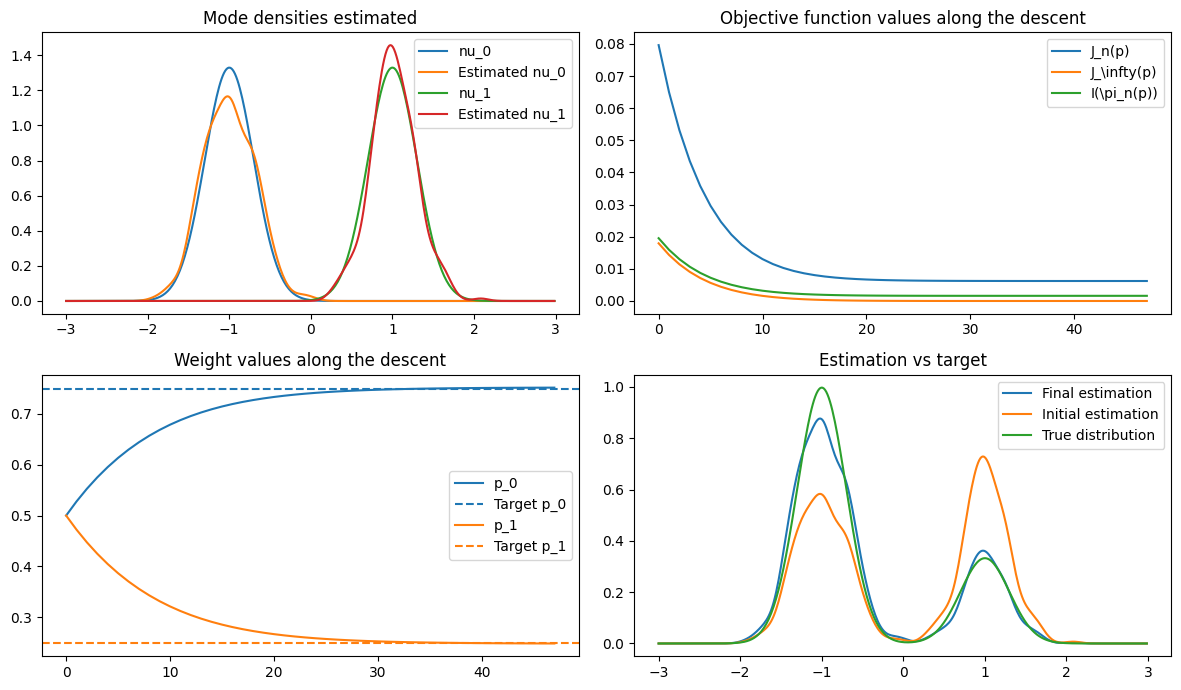

In [8]:
display_graph(solver, X_eval, n_center, centers, sigma_star, X_samples, U, nu, p_star)

### INCREASING N (Table 1)

In [ ]:
storage_folder = 'table_storage'
file_name_output = 'few_datapoints_evolution'

#### Sampling ####

n_dataset = 15
n_tot = 1600
sample_repartition = np.ones((n_center))/n_center # equal
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding

X_dataset = []
U_dataset = []
for j in range(n_dataset):
    X_samples, U_samples = [], []
    for i in range(n_center):
        X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
        U_samples.append(U(X_samples[-1]))
    X_dataset.append(X_samples)
    U_dataset.append(U_samples)

#### Gradient descent for various number of data ####

h = 0.1
max_iter = 200
accuracy = 0.00001
p0 = np.ones((n_center))/n_center
KL_type = 0

sample_limitations = [25, 50, 100, 200, 400, 800]
n_limitations = len(sample_limitations)
labels = '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
n_columns = len(labels)
collection = np.zeros((n_limitations, n_dataset, n_columns))

n_quad = 1200
X_quad = (4*(2*np.arange(n_quad)/n_quad - 1)).reshape(-1,1) # integrals computed on [-4, 4]

for j in range(n_dataset):
    print('----<#### Dataset '+str(j)+' ####>----')
    for k in range(len(sample_limitations)):
        ## Data limitation to k ##
        
        n_lim = sample_limitations[k]
        print('** Starting batch for '+str(n_lim)+' datapoints **')
        X_limited, U_samples_limited = [], []
        for i in range(n_center):
            X_limited.append(X_dataset[j][i][:n_lim])
            U_samples_limited.append(U_dataset[j][i][:n_lim])

        ## Training ##
        solver = mode_weights.GD_estimator(KL_type, p0, U_samples_limited, X_limited, h, accuracy, max_iter, ['silverman']*n_center)
        solver.optimise()

        alpha = solver.alpha
        p_final = solver.p_list[-1]
        ## Data collection ##
        '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
        batch_collection = np.array([p_final[0], solver.surrogate_function(p_final), solver.objective_function(U, nu, X_quad, p_final), solver.KL(U, X_quad)]) # solver.objective_function_measure(U, X_quad)
        collection[k][j] = batch_collection

file_path = storage_folder + '/' + file_name_output + ".npy" 
np.save(file_path, collection)
file_path = storage_folder + '/' + file_name_output + ".txt"
with open(file_path, "w") as f:
    f.write(repr(sample_limitations) + "\n")
    f.write(repr(labels))

----<#### Dataset 0 ####>----
** Starting batch for 25 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 62 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 50 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 65 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 100 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 65 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 200 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done

## OVERLAPPING MODES

### INCREASING SIGMA (Table 2)

In [94]:
storage_folder = "table_storage"
file_name_output = 'closer_modes_data'

sigma_star_list = [[0.3]*2, [0.4]*2, [0.5]*2, [0.6]*2, [0.65]*2, [0.7]*2, [0.75]*2, [0.8]*2]
n_limitations = len(sigma_star_list)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X, sigma):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma[i])
    return -np.log(density_value)

def nu_1(X, sigma):
    return g(X - centers[0], sigma[0])

def nu_2(X, sigma):
    return g(X - centers[1], sigma[1])

nu = [nu_1, nu_2]

#### Sampling ####

n_dataset = 15
n_tot = 600
sample_repartition = np.ones((n_center))/n_center # equal
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding

X_dataset = []
U_dataset = []
for j in range(n_dataset):
    X_dataset.append([])
    U_dataset.append([])
    for k in range(len(sigma_star_list)):
        X_samples, U_samples = [], []
        for i in range(n_center):
            X_samples.append( np.random.normal(0, sigma_star_list[k][i], (n_samples[i],dim)) + centers[i] )
            U_samples.append(U(X_samples[-1], sigma_star_list[k]))
        X_dataset[-1].append(X_samples)
        U_dataset[-1].append(U_samples)

#### Gradient descent for various number of data ####

h = 0.1
max_iter = 200
accuracy = 0.00001
p0 = np.ones((n_center))/n_center
KL_type = 0

labels = '$p_f$'
n_columns = len(labels)
collection = np.zeros((n_limitations, n_dataset, n_columns))

n_quad = 1200
X_quad = (4*(2*np.arange(n_quad)/n_quad - 1)).reshape(-1,1) # integrals computed on [-4, 4]

for j in range(n_dataset):
    print('----<#### Dataset '+str(j)+' ####>----')
    for k in range(len(sigma_star_list)):
        ## Data limitation to k ##
        
        sigma_star = sigma_star_list[k]
        print('** Starting batch for '+str(sigma_star)+' standard deviation **')
        X_limited, U_samples_limited = X_dataset[j][k], U_dataset[j][k]

        ## Training ##
        solver = mode_weights.GD_estimator(KL_type, p0, U_samples_limited, X_limited, h, accuracy, max_iter, ['silverman']*n_center)
        solver.optimise()

        alpha = solver.alpha
        p_final = solver.p_list[-1]
        ## Data collection ##
        '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
        batch_collection = np.array([p_final[0]]) # solver.objective_function_measure(U, X_quad)
        collection[k][j] = batch_collection

file_path = os.path.join(storage_folder, file_name_output + ".npy")
np.save(file_path, collection)
file_path = os.path.join(storage_folder, file_name_output + ".txt")
with open(file_path, "w") as f:
    f.write(repr(sigma_star_list) + "\n")
    f.write(repr(labels))

----<#### Dataset 0 ####>----
** Starting batch for [0.3, 0.3] standard deviation **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 64 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for [0.4, 0.4] standard deviation **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 65 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for [0.5, 0.5] standard deviation **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Gradient descent done ; In 52 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for [0.6, 0.6] standard deviation **
Starting bandwidth computations

### INCREASING N (Table 3)

In [99]:
n_center = 2
dim = 1
centers = np.array([np.array([-1]), np.array([1])]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = 0.6, 0.6 #np.random.uniform(sigma_min, sigma_max , (n_center))
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return g(X - centers[0], sigma_star[0])

def nu_2(X):
    return g(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

storage_folder = "table_storage"
file_name_output = 'closer_modes_varying_n'

#### Sampling ####

n_dataset = 15
n_tot = 12800
sample_repartition = np.ones((n_center))/n_center # equal
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding

X_dataset = []
U_dataset = []
for j in range(n_dataset):
    X_samples, U_samples = [], []
    for i in range(n_center):
        X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
        U_samples.append(U(X_samples[-1]))
    X_dataset.append(X_samples)
    U_dataset.append(U_samples)

#### Gradient descent for various number of data ####

h = 0.1
max_iter = 200
accuracy = 0.00001
p0 = np.ones((n_center))/n_center
KL_type = 0

sample_limitations = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
n_limitations = len(sample_limitations)
labels = '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
n_columns = len(labels)
collection = np.zeros((n_limitations, n_dataset, n_columns))

n_quad = 1200
X_quad = (4*(2*np.arange(n_quad)/n_quad - 1)).reshape(-1,1) # integrals computed on [-4, 4]

for j in range(n_dataset):
    print('----<#### Dataset '+str(j)+' ####>----')
    for k in range(len(sample_limitations)):
        ## Data limitation to k ##
        
        n_lim = sample_limitations[k]
        print('** Starting batch for '+str(n_lim)+' datapoints **')
        X_limited, U_samples_limited = [], []
        for i in range(n_center):
            X_limited.append(X_dataset[j][i][:n_lim])
            U_samples_limited.append(U_dataset[j][i][:n_lim])

        ## Training ##
        solver = mode_weights.GD_estimator(KL_type, p0, U_samples_limited, X_limited, h, accuracy, max_iter, ['silverman']*n_center)
        solver.optimise()

        alpha = solver.alpha
        p_final = solver.p_list[-1]
        ## Data collection ##
        '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
        batch_collection = np.array([p_final[0], solver.surrogate_function(p_final), solver.objective_function(U, nu, X_quad, p_final), solver.KL(U, X_quad)]) # solver.objective_function_measure(U, X_quad)
        collection[k][j] = batch_collection

file_path = storage_folder + '/' + file_name_output + ".npy"
np.save(file_path, collection)
file_path = storage_folder + '/' + file_name_output + ".txt"
with open(file_path, "w") as f:
    f.write(repr(sample_limitations) + "\n")
    f.write(repr(labels))

----<#### Dataset 0 ####>----
** Starting batch for 25 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 73 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 50 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 62 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 100 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 63 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 200 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done.

KeyboardInterrupt: 

## MORE MODES 1D (Table 4)

In [101]:
# Target definition and data generation

n_center = 5
dim = 1
centers = np.array([np.array([-4]), np.array([-2]), np.array([0]), np.array([2]), np.array([4])]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = [0.3]*n_center
c_star = np.array([0.12, 0.34, 0.08, 0.22, 0.24])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma_star[i])
    return -np.log(density_value)

nu = []

for i in range(n_center):
    nu.append(lambda X, i=i: g(X - centers[i], sigma_star[i]))


storage_folder = "table_storage"
file_name_output = 'more_modes'

#### Sampling ####

n_dataset = 15
n_tot = 4000
sample_repartition = np.ones((n_center))/n_center # equal
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding

X_dataset = []
U_dataset = []
for j in range(n_dataset):
    X_samples, U_samples = [], []
    for i in range(n_center):
        X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
        U_samples.append(U(X_samples[-1]))
    X_dataset.append(X_samples)
    U_dataset.append(U_samples)

#### Gradient descent for various number of data ####

h = 0.1
max_iter = 200
accuracy = 0.00001
p0 = np.ones((n_center))/n_center
KL_type = 0

sample_limitations = [25, 50, 100, 200, 400, 800]
n_limitations = len(sample_limitations)
labels = '$p_{0,f}$', '$p_{1,f}$', '$p_{2,f}$', '$p_{3,f}$', '$p_{4,f}$'
n_columns = len(labels)
collection = np.zeros((n_limitations, n_dataset, n_columns))

n_quad = 1200
X_quad = (4*(2*np.arange(n_quad)/n_quad - 1)).reshape(-1,1) # integrals computed on [-4, 4]

for j in range(n_dataset):
    print('----<#### Dataset '+str(j)+' ####>----')
    for k in range(len(sample_limitations)):
        ## Data limitation to k ##
        
        n_lim = sample_limitations[k]
        print('** Starting batch for '+str(n_lim)+' datapoints **')
        X_limited, U_samples_limited = [], []
        for i in range(n_center):
            X_limited.append(X_dataset[j][i][:n_lim])
            U_samples_limited.append(U_dataset[j][i][:n_lim])

        ## Training ##
        solver = mode_weights.GD_estimator(KL_type, p0, U_samples_limited, X_limited, h, accuracy, max_iter, ['silverman']*n_center)
        solver.optimise()

        alpha = solver.alpha
        p_final = solver.p_list[-1]
        ## Data collection ##
        '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
        batch_collection = np.array([p_final[0], p_final[1], p_final[2], p_final[3], p_final[4]])/p_star # solver.objective_function_measure(U, X_quad)
        collection[k][j] = batch_collection

file_path = storage_folder + '/' + file_name_output + ".npy"
np.save(file_path, collection)
file_path = storage_folder + '/' + file_name_output + ".txt"
with open(file_path, "w") as f:
    f.write(repr(sample_limitations) + "\n")
    f.write(repr(labels))

----<#### Dataset 0 ####>----
** Starting batch for 25 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Gradient descent done ; In 91 iterations, the minimum displacement has been reached.
Took 0.03s.
** Starting batch for 50 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Gradient descent done ; In 95 iterations, the minimum displacement has been reached.
Took 0.03s.
** Starting batch for 100 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Gradient descent done ; In 94 iterations, the minimum displacement has been reached.
Took 0.03s.
** Starting batch for 200 datapoints **
Starting bandwidth computations and KDE e

KeyboardInterrupt: 

### HIGH DIMENSION (Table 5)

In [112]:
storage_folder = "table_storage"
file_name_output = 'high_d_low_sigma'

n_center = 2
dim = 10
centers = np.array([np.array([-1] + [0]*(dim-1)), np.array([1] + [0]*(dim-1))]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = 0.3, 0.3 #np.random.uniform(sigma_min, sigma_max , (n_center))
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return g(X - centers[0], sigma_star[0])

def nu_2(X):
    return g(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

#### Sampling ####

n_dataset = 15
n_tot = 12800
sample_repartition = np.ones((n_center))/n_center # equal
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding

X_dataset = []
U_dataset = []
for j in range(n_dataset):
    X_samples, U_samples = [], []
    for i in range(n_center):
        X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
        U_samples.append(U(X_samples[-1]))
    X_dataset.append(X_samples)
    U_dataset.append(U_samples)

#### Gradient descent for various number of data ####

h = 1
max_iter = 200
accuracy = 0.00001
p0 = np.ones((n_center))/n_center
KL_type = 0

sample_limitations = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
n_limitations = len(sample_limitations)
labels = '$p_f$'
n_columns = len(labels)
collection = np.zeros((n_limitations, n_dataset, n_columns))

import numpy as np
from itertools import product

def generate_grid(dim: int, n_quad: int):
    axis_points = np.linspace(-4, 4, n_quad)
    grid = np.array(list(product(axis_points, repeat=dim)))
    return grid

for j in range(n_dataset):
    print('----<#### Dataset '+str(j)+' ####>----')
    for k in range(len(sample_limitations)):
        ## Data limitation to k ##
        
        n_lim = sample_limitations[k]
        print('** Starting batch for '+str(n_lim)+' datapoints **')
        X_limited, U_samples_limited = [], []
        for i in range(n_center):
            X_limited.append(X_dataset[j][i][:n_lim])
            U_samples_limited.append(U_dataset[j][i][:n_lim])

        ## Training ##
        solver = mode_weights.GD_estimator(KL_type, p0, U_samples_limited, X_limited, h, accuracy, max_iter, ['silverman']*n_center)
        solver.optimise()

        alpha = solver.alpha
        p_final = solver.p_list[-1]
        ## Data collection ##
        '$p_f$'
        batch_collection = np.array([p_final[0]]) # solver.objective_function_measure(U, X_quad)
        collection[k][j] = batch_collection

file_path = storage_folder +'/'+ file_name_output + ".npy"
np.save(file_path, collection)
file_path = storage_folder + '/' + file_name_output + ".txt"
with open(file_path, "w") as f:
    f.write(repr(sample_limitations) + "\n")
    f.write(repr(labels))

----<#### Dataset 0 ####>----
** Starting batch for 25 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Gradient descent done ; In 157 iterations, the minimum displacement has been reached.
Took 0.02s.
** Starting batch for 50 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Gradient descent done ; In 127 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 100 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Gradient descent done ; In 125 iterations, the minimum displacement has been reac

KeyboardInterrupt: 

### HIGH DIMENSION (Figure 3)

In [106]:
sample_repartition = np.ones((n_center))/n_center # equal
n_tot = 12800*2
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
    U_samples.append(U(X_samples[-1]))

# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 1
max_iter = 400
eps = 0.0001
KL_type = 0
bw = ['silverman']*n_center

solver = mode_weights.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))

Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 22.94s.
Iteration 0
Iteration 20
Gradient descent done ; In 33 iterations, the minimum displacement has been reached.
Took 0.01s.
Ideal weights: [0.75 0.25]
Estimated weights: [0.74844421 0.25155579]


In [107]:
def display_graph_high_d(solver, X_eval, n_center, centers, sigma_star, X_samples, U, p_star, jj=0):

    alpha = solver.alpha

    fig,ax = plt.subplots(2,2)
    fig.set_size_inches(12,7)

    estimated_modes = []
    real_modes = []
    for i in range(n_center):
        real_modes.append(g(X_eval - centers[i], sigma_star[i]))
        estimated_modes.append(mode_weights.KDE_evaluation(X_samples[i], X_eval, alpha[i]))
        ax[0][0].plot(X_eval[:,jj], real_modes[-1], label='nu_'+str(i))
        ax[0][0].plot(X_eval[:,jj], estimated_modes[-1], label='Estimated nu_'+str(i))

    ax[0][0].set_title('Mode densities estimated')
    ax[0][0].legend()

    y_1 = []
    for i in range(len(solver.p_list)):
        val = solver.surrogate_function(solver.p_list[i])
        y_1.append(val)
    ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='J_n(p)')
    ax[0][1].set_title('Objective function values along the descent')
    ax[0][1].legend()

    ax[0][1].set_title('Objective function values along the descent')
    ax[0][1].legend()

    for i in range(n_center):
        a = ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
        ax[1][0].axhline(y=p_star[i], linestyle='dashed', label='Target p_'+str(i), color=a[0].get_color())
    ax[1][0].set_title('Weight values along the descent')
    ax[1][0].legend()

    y = solver.evaluate(X_eval, solver.p_list[-1])
    z = solver.evaluate(X_eval, solver.p_list[0])
    ax[1][1].plot(X_eval[:,jj], y, label='Final estimation')
    ax[1][1].plot(X_eval[:,jj], z, label='Initial estimation')
    ax[1][1].plot(X_eval[:,jj], np.exp(-U(X_eval)), label='True distribution')
    ax[1][1].set_title('Estimation vs target')
    ax[1][1].legend()

    plt.tight_layout()
    plt.show()

X_eval_bis = np.concatenate([3 * ((np.arange(400)/400)*2-1).reshape(-1,1), np.zeros((400, dim-1))], axis=1)

X_eval_bis_bis = np.zeros((400, dim))
ii = 1
X_eval_bis_bis[:,ii] = 3 * ((np.arange(400)/400)*2-1)
X_eval_bis_bis[:,0] = np.ones((400))

mode_focus = -0.8

n_eval = 400
X_eval_coordinates = []
for i in range(dim):
    X_eval_coordinate = np.zeros((n_eval, dim))
    X_eval_coordinate[:,0] = mode_focus * np.ones((n_eval))
    X_eval_coordinate[:,i] = 3 * ((np.arange(n_eval)/n_eval)*2-1)

    X_eval_coordinates.append(X_eval_coordinate)


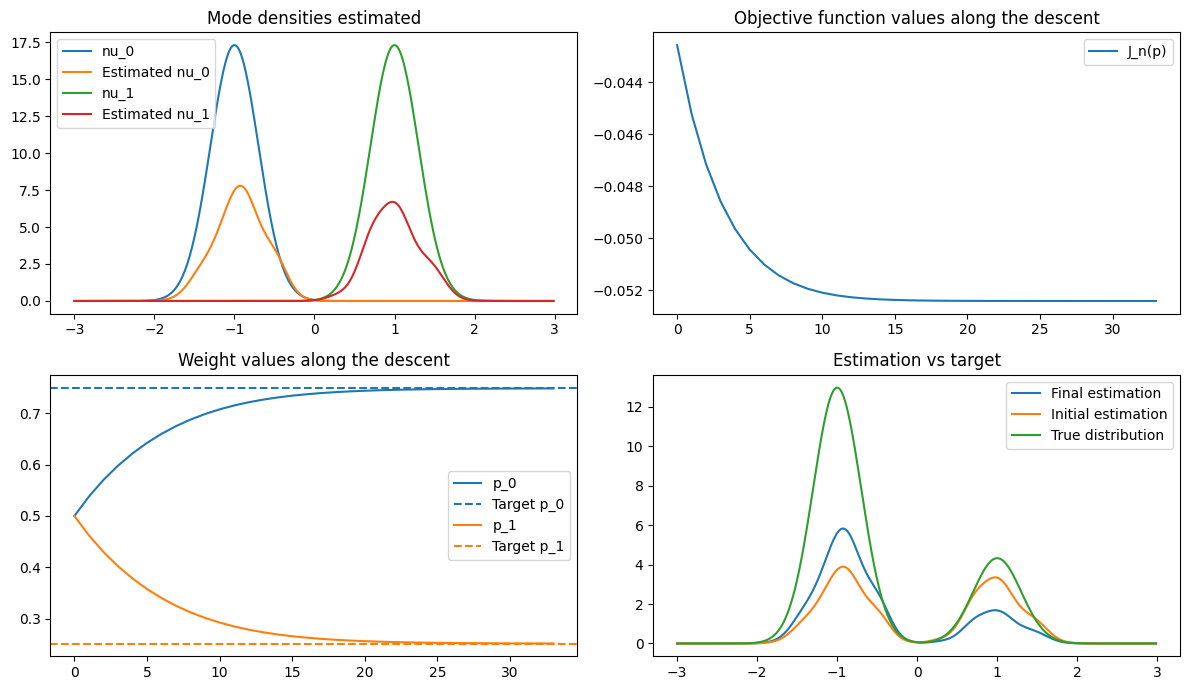

In [110]:
coordinate = 0
X_eval_coordinate = X_eval_coordinates[coordinate]

display_graph_high_d(solver, X_eval_coordinate, n_center, centers, sigma_star, X_samples, U, p_star, coordinate)

# Regularised

(800, 800)
(800, 800)
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 85
Iteration 90
Iteration 95
Iteration 100
Iteration 105
Iteration 110
Iteration 115
Iteration 120
Iteration 125
Iteration 130
Iteration 135
Iteration 140
Iteration 145
Iteration 150
Iteration 155
Iteration 160
Iteration 165
Iteration 170
Iteration 175
Iteration 180
Iteration 185
Iteration 190
Iteration 195
Iteration 200
Iteration 205
Iteration 210
Iteration 215
Iteration 220
Iteration 225
Iteration 230
Iteration 235
Iteration 240
Iteration 245
Iteration 250
Iteration 255
Iteration 260
Iteration 265
Iteration 270
Iteration 275
Iteration 280
Iteration 285
Iteration 290
Iteration 295
Iteration 300
Iteration 305
Iteration 310
Iteration 315
Iteration 320
Iteration 325
Iteration 330
Iteration 335
Iteration 340
Iteration 345
Iteration 350
Iterat

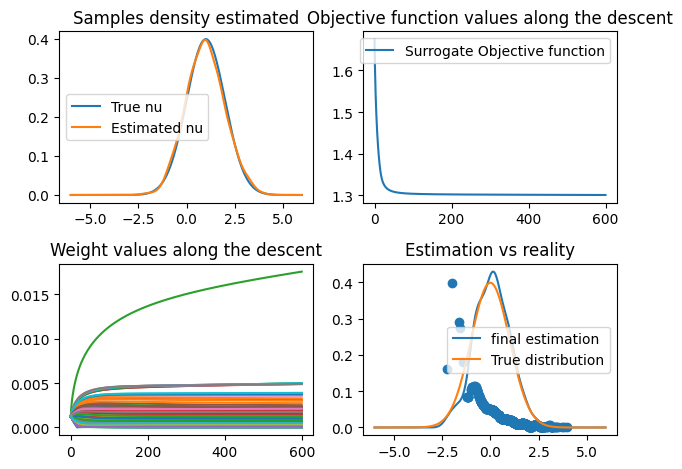

In [8]:
#Target preparation:

def g(X, sigma): # X:(n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def sample_from_nu(n_samples, p_sampling, sampling_centers, sigma_samples, d):
    
    arr = p_sampling * n_samples
    out = np.empty_like(arr, dtype=np.int64)
    n_samples_repartition = np.ceil(arr, out, casting='unsafe')
    n_tot = np.sum(n_samples_repartition)
    X = []
    for i in range(len(n_samples_repartition)):
        X.append(np.random.normal(0, sigma_samples[i], (n_samples_repartition[i], d)) + sampling_centers[i])
    return np.concatenate(X, axis=0)


dim = 1

sampling_centers = np.array([np.array([1])])#np.array([np.array([-0.8]), np.array([1.1])])
n_sampling_centers = len(sampling_centers)
sigma_samples = [1]
c_sampling = np.array([1])
p_sampling = c_sampling/np.sum(c_sampling)

true_centers = np.array([np.array([0])])#np.array([np.array([-1]), np.array([1])])
n_true_centers = len(true_centers)
sigma_star = [1]
c_star = np.array([1])
p_star = c_star/np.sum(c_star)

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_true_centers):
        density_value += p_star[i] * g(X - true_centers[i], sigma_star[i])
    return -np.log(density_value)

def nu(X):
    density_value = np.zeros((len(X)))
    for i in range(n_sampling_centers):
        density_value += p_sampling[i] * g(X - sampling_centers[i], sigma_samples[i])
    return density_value

n_samples = 800

X_samples = sample_from_nu(n_samples, p_sampling, sampling_centers, sigma_samples, dim)
U_samples = U(X_samples)

# Algorithm parametrisation:

p0 = np.ones((n_samples))/n_samples
h = 0.0001
max_iter = 600
eps = 0.00001
KL_type = 0
bw = 'cv_ml'
reg_types = ['h_1', 'l_2']
reg_constants = [0.01, 0.001]


solver = particle_weights.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw, reg_types, reg_constants)

solver.optimise()

# Display

alpha = solver.alpha

fig,ax = plt.subplots(2,2)

X_eval = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
estimated_modes = particle_weights.KDE_evaluation(X_samples, X_eval, alpha)
real_modes = nu(X_eval)
ax[0][0].plot(X_eval, real_modes, label='True nu')
ax[0][0].plot(X_eval, estimated_modes, label='Estimated nu')
ax[0][0].set_title('Samples density estimated')
ax[0][0].legend()

y_1 = []
for i in range(len(solver.p_list)):
    val = solver.surrogate_function(solver.p_list[i])[0]
    y_1.append(val)
ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='Surrogate Objective function')
ax[0][1].set_title('Objective function values along the descent')
ax[0][1].legend()

for i in range(n_samples):
    if i%5==0:# One every 5 is displayed
        ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
ax[1][0].set_title('Weight values along the descent')

y = solver.evaluate(X_eval, solver.p_list[-1])
z = np.exp(-U(X_eval))
ax[1][1].plot(X_eval, y, label='final estimation')
ax[1][1].plot(X_eval, z, label='True distribution')
ax[1][1].scatter(X_samples, solver.p_list[-1] * max(z) / max(solver.p_list[-1]))
ax[1][1].set_title('Estimation vs reality')
ax[1][1].legend()

plt.tight_layout()
plt.show()